## Introduction

### The Covid crisis has highlighted the need for easy access to open spaces for citizens, especially those who live in apartments and may not have a private garden.  As a result, many are looking to move to neighbourhoods and suburbs with parks and leisure facilities, especially those that can be reached by walking.  In London, historically there has always a migration from the city centre towards the suburbs.  Young couples or recent immigrants start off in apartments near the city centre, where night life and pubs are abundant, and as they mature, they seek areas where houses with gardens are more abundant and affordable, and the quality of schooling is often better.  Covid has accelerated this trend.

### This project aims to identify which boroughs and suburbs in East London are the most attractive in terms of parks and open spaces.  I have chosen East London because the migration from the centre of London is often towards the east because housing there is relatively cheap (the 'East End' was heavily bombed during the Second World War) compared to the wealthier north, west and south of London.  I also live in East London so it is of personal interest to me.


## Data Sources

### In this project, I plan to scrape a list of London suburbs from Wikipedia, filter it down to the suburbs within the eight London boroughs in E/NE London, and use the Foursquare API to get venues information on those suburbs.  I will then use KMeans to cluster the data to identify which areas have the most parks and open spaces.  

## 1. Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 


import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


## 2. Scrape London Suburbs data from Wikipedia

In [2]:
## Visit the page and see the attributes of the desired table in page source code.  In Firefox code inspection mode can be enabled with Ctrl+Shift+C

## Get page into Python


import requests

url_="https://en.wikipedia.org/wiki/List_of_areas_of_London"
class_="wikitable"

response=requests.get(url_)
if response.status_code == 200:
    print('Successfully loaded {}'.format(url_))
else:
    raise Exception('Experienced a problem while loading {url} : {code}'.format(url=url_, code=response.status_code))

Successfully loaded https://en.wikipedia.org/wiki/List_of_areas_of_London


In [3]:
## import beautifulsoup for parsing HTML
from bs4 import BeautifulSoup as bs

# Parse the response.text with an html parser
# lxml is one of the faster parsers out there, but you may use 'html.parser' as well
soup = bs(response.text, 'lxml')

# This line finds all tables with a class we specified in variable class_ in the entire webpage.
# all_tables will be a list of all matches
all_tables = soup.find_all('table')

print('Found {} objects of attribute type \'table\''.format(len(all_tables)))

Found 5 objects of attribute type 'table'


In [4]:
## Find our table with class 'wikitable'
table = soup.find_all('table', class_=class_)
print('Found {} objects of attribute type \'table\' and class \'{}\''.format(len(table), class_))

Found 1 objects of attribute type 'table' and class 'wikitable'


## 3. Take html into pandas dataframe

In [5]:
# Automatic parsing via Pandas. NOTE: It loads data as List, not as DataFrame
df_list = pd.read_html(str(table))

# So we make it into a dataframe:
df = pd.DataFrame(df_list[0])
# Let's replace spaces with underscores for convenience
display(df.head())

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


## 4. Extract lat/Longs using Nominatim and a function to apply to each row of the dataframe

In [6]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

locator = Nominatim(user_agent="myGeocoder")
# We are using RateLimiter to not overload the public service.
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

def get_geo(location):
    try:
        geo = geocode(location)
    except:
        print("Error! Connection failed for location {}!".format(location))
    if geo:
        return geo.latitude or 'Lat Not Found', geo.longitude or 'Long Not Found'
    else:
        # THIS SPECIFIC GEOCODER FOUND NO COORDINATES BY THAT ADDRESS
        return "No location"

In [7]:
## Test function with location for London

get_geo('London')

(51.5073219, -0.1276474)

In [8]:
## Define search name for all locations
df['SearchLocation'] = df["Post town"] + ", " + df['Location']
df.head()

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref,SearchLocation
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785,"LONDON, Abbey Wood"
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805,"LONDON, Acton"
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645,"CROYDON, Addington"
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665,"CROYDON, Addiscombe"
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728,"BEXLEY, SIDCUP, Albany Park"


In [9]:
## Let's test getting locations on a smaller dataframe:

df_test = df[:5]

df_test['Geodata'] = df_test['SearchLocation'].apply(get_geo)
df_test.head()

<ipython-input-9-51f6e5436db7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Geodata'] = df_test['SearchLocation'].apply(get_geo)


,Location,London borough,Post town,Postcode district,Dial code,OS grid ref,SearchLocation,Geodata
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785,"LONDON, Abbey Wood","(51.487621, 0.1140504)"
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805,"LONDON, Acton","(51.5081402, -0.2732607)"
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645,"CROYDON, Addington","(44.4206405, -76.978248)"
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665,"CROYDON, Addiscombe","(51.3796916, -0.0742821)"
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728,"BEXLEY, SIDCUP, Albany Park","(51.4353837, 0.1259653)"


In [10]:
## Get locations for all suburbs
df['Geodata'] = df['SearchLocation'].apply(get_geo)
df.head()

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref,SearchLocation,Geodata
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785,"LONDON, Abbey Wood","(51.487621, 0.1140504)"
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805,"LONDON, Acton","(51.5081402, -0.2732607)"
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645,"CROYDON, Addington","(44.4206405, -76.978248)"
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665,"CROYDON, Addiscombe","(51.3796916, -0.0742821)"
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728,"BEXLEY, SIDCUP, Albany Park","(51.4353837, 0.1259653)"


In [11]:
## Check size of dataframe
df.shape

(531, 8)

In [12]:
## examine data for filtering down to East London
df["Post town"].unique()

array(['LONDON', 'CROYDON', 'BEXLEY, SIDCUP', 'ILFORD', 'WEMBLEY',
       'WESTERHAM', 'HORNCHURCH', 'BARNET, LONDON', 'BARKING',
       'BEXLEYHEATH', 'DARTFORD', 'LONDON, BARNET', 'BARNET',
       'BECKENHAM, LONDON', 'LONDON, BARKING', 'DAGENHAM',
       'WALLINGTON, CROYDON', 'HARROW, STANMORE', 'SUTTON', 'BELVEDERE',
       'SURBITON', 'BEXLEY', 'BEXLEYHEATH, LONDON', 'BROMLEY', 'SIDCUP',
       'ENFIELD', 'BRENTFORD', 'EDGWARE', 'CARSHALTON', 'ROMFORD',
       'SUTTON/MERTON', 'ORPINGTON', 'CHESSINGTON', 'CHISLEHURST',
       'ERITH', 'WEST WICKHAM', 'KINGSTON UPON THAMES', 'COULSDON',
       'UXBRIDGE', 'HOUNSLOW', 'UPMINSTER', 'SEVENOAKS', 'FELTHAM',
       'WELLING', 'PINNER', 'BECKENHAM', 'TWICKENHAM', 'LONDON, WELLING',
       'TEDDINGTON, HAMPTON', 'GREENFORD', 'CHIGWELL', 'RICHMOND',
       'HAMPTON', 'HAYES', 'WEST DRAYTON', 'HARROW', 'ISLEWORTH',
       'KENLEY', 'HARROW, LONDON', 'KESTON', 'LONDON, SIDCUP', 'MORDEN',
       'MITCHAM', 'NEW MALDEN', 'NORTHOLT', 'NORTHWOO

In [13]:
## examine data for filtering down to East London subset
for col in df:
    print(df[col].unique())

['Abbey Wood' 'Acton' 'Addington' 'Addiscombe' 'Albany Park'
 'Aldborough Hatch' 'Aldgate' 'Aldwych' 'Alperton' 'Anerley' 'Angel'
 'Aperfield' 'Archway' 'Ardleigh Green' 'Arkley' 'Arnos Grove' 'Balham'
 'Bankside' 'Barbican' 'Barking' 'Barkingside' 'Barnehurst' 'Barnes'
 'Barnes Cray' 'Barnet Gate' 'Barnet (also Chipping Barnet, High Barnet)'
 'Barnsbury' 'Battersea' 'Bayswater' 'Beckenham' 'Beckton' 'Becontree'
 'Becontree Heath' 'Beddington' 'Bedford Park' 'Belgravia' 'Bellingham'
 'Belmont' 'Belsize Park' 'Belvedere' 'Bermondsey' 'Berrylands'
 'Bethnal Green' 'Bexley (also Old Bexley, Bexley Village)'
 'Bexleyheath (also Bexley New Town)' 'Bickley' 'Biggin Hill' 'Blackfen'
 'Blackfriars' 'Blackheath' 'Blackheath Royal Standard' 'Blackwall'
 'Blendon' 'Bloomsbury' 'Botany Bay' 'Bounds Green' 'Bow' 'Bowes Park'
 'Brentford' 'Brent Cross' 'Brent Park' 'Brimsdown' 'Brixton' 'Brockley'
 'Bromley' 'Bromley (also Bromley-by-Bow)' 'Bromley Common' 'Brompton'
 'Brondesbury' 'Brunswick Park' 

## 5. Clean data; drop unwanted columns and slice to boroughs in East London north of the river Thames

In [14]:
## unable to drop 'Postcode district' and 'Dial code'; pandas doesn't like spaces in column name, so renamed and dropped unwanted columns
df.columns = ['Location', 'borough', 'post_town', 'post_district', 'dial_code', 'grid', 'SearchLocation', 'Geodata']
df.drop(columns=['post_town', 'post_district', 'dial_code', 'grid', 'SearchLocation'], axis=1, inplace=True)

In [15]:
## List Columns in dataframe
df.columns

Index(['Location', 'borough', 'Geodata'], dtype='object')

In [16]:
## examine data for filtering down to East London
df["borough"].unique()

array(['Bexley, Greenwich [7]', 'Ealing, Hammersmith and Fulham[8]',
       'Croydon[8]', 'Bexley', 'Redbridge[9]', 'City[10]',
       'Westminster[10]', 'Brent[11]', 'Bromley[11]', 'Islington[8]',
       'Islington[12]', 'Havering[12]', 'Barnet[12]', 'Enfield[12]',
       'Wandsworth[13]', 'Southwark[14]', 'City[14]',
       'Barking and Dagenham[14]', 'Redbridge[15]', 'Bexley[15]',
       'Richmond upon Thames[15]', 'Bexley[16]', 'Barnet', 'Barnet[16]',
       'Islington[17]', 'Wandsworth[18]', 'Westminster[19]',
       'Bromley[20]', 'Newham[20]', 'Barking and Dagenham[20]',
       'Barking and Dagenham[21]', 'Sutton[21]', 'Ealing[21]',
       'Westminster[22]', 'Lewisham[22]', 'Harrow[22]', 'Sutton[22]',
       'Camden[23]', 'Bexley[23]', 'Southwark[24]',
       'Kingston upon Thames[24]', 'Tower Hamlets[25]', 'Bexley[25]',
       'Bexley[26]', 'Bromley[26]', 'Bexley[27]', 'City[27]',
       'Lewisham[28]', 'Greenwich', 'Tower Hamlets[28]', 'Camden[29]',
       'Enfield[30]', 'Hari

In [17]:
df['Geodata']=df['Geodata'].astype(str)
df['Geodata'].dtype

dtype('O')

In [18]:
## Separate 'grid' column into 'latitude' and 'longitude' columns
df['Geodata']=df['Geodata'].str.replace(" ","").str.strip('(').str.strip(')')
df['latitude']=df['Geodata'].str.split(',').str[0]
df['longitude']=df['Geodata'].str.split(',').str[1]
df.head(10)

,Location,borough,Geodata,latitude,longitude
0,Abbey Wood,"Bexley, Greenwich [7]","51.487621,0.1140504",51.487621,0.1140504
1,Acton,"Ealing, Hammersmith and Fulham[8]","51.5081402,-0.2732607",51.5081402,-0.2732607
2,Addington,Croydon[8],"44.4206405,-76.978248",44.4206405,-76.978248
3,Addiscombe,Croydon[8],"51.3796916,-0.0742821",51.3796916,-0.0742821
4,Albany Park,Bexley,"51.4353837,0.1259653",51.4353837,0.1259653
5,Aldborough Hatch,Redbridge[9],Nolocation,Nolocation,NaN
6,Aldgate,City[10],"51.5142477,-0.0757186",51.5142477,-0.0757186
7,Aldwych,Westminster[10],"51.5131312,-0.1175934",51.5131312,-0.1175934
8,Alperton,Brent[11],"51.5408036,-0.3000963",51.5408036,-0.3000963
9,Anerley,Bromley[11],"51.4075993,-0.0619394",51.4075993,-0.0619394


In [19]:
## Strip dataframe to boroughs in East London near where I live
ELondon_df = df[df["borough"].str.contains("Redbridge|City|Havering|Barking and Dagenham|Tower Hamlets|Haringey|Waltham Forest|Hackney")].reset_index(drop=True)
ELondon_df.head()

,Location,borough,Geodata,latitude,longitude
0,Aldborough Hatch,Redbridge[9],Nolocation,Nolocation,NaN
1,Aldgate,City[10],"51.5142477,-0.0757186",51.5142477,-0.0757186
2,Ardleigh Green,Havering[12],"51.5712468,0.2190799",51.5712468,0.2190799
3,Barbican,City[14],"51.5201501,-0.0986832",51.5201501,-0.0986832
4,Barking,Barking and Dagenham[14],"51.5402677,0.0793235",51.5402677,0.0793235


In [20]:
## Drop 'Geodata column
ELondon_df.drop(columns=['Geodata'], axis=1, inplace=True)
ELondon_df.head(20)

,Location,borough,latitude,longitude
0,Aldborough Hatch,Redbridge[9],Nolocation,NaN
1,Aldgate,City[10],51.5142477,-0.0757186
2,Ardleigh Green,Havering[12],51.5712468,0.2190799
3,Barbican,City[14],51.5201501,-0.0986832
4,Barking,Barking and Dagenham[14],51.5402677,0.0793235
5,Barkingside,Redbridge[15],51.581935349999995,0.07005708323668366
6,Becontree,Barking and Dagenham[20],51.5403111,0.1265241
7,Becontree Heath,Barking and Dagenham[21],51.5610299,0.1478793
8,Bethnal Green,Tower Hamlets[25],51.5303456,-0.0561633
9,Blackfriars,City[27],51.5115854,-0.1037671


In [21]:
ELondon_df = df[df["borough"].str.contains("Redbridge|City|Havering|Barking and Dagenham|Tower Hamlets|Waltham Forest|Hackney")].reset_index(drop=True)

In [22]:
## Make copy of Dataframe
ELondondf_new = ELondon_df.copy()

In [23]:
ELondon_df.describe()

,Location,borough,Geodata,latitude,longitude
count,97,97,97,97,94
unique,97,25,91,91,90
top,Hackney Marshes,Havering,Nolocation,Nolocation,0.2516815
freq,1,20,3,3,2


In [24]:
## Drop rows with NaN values
ELondon_clean = ELondondf_new.dropna()
ELondon_clean = ELondon_clean.reset_index(drop=True)
ELondon_clean.describe()

,Location,borough,Geodata,latitude,longitude
count,94,94,94,94,94
unique,94,23,90,90,90
top,Hackney Marshes,Havering,"51.5432402,-0.0493621",51.5589375,0.2516815
freq,1,19,2,2,2


In [25]:
## Drop rows with NaN values from ELondon_df
ELondon_df2 = ELondon_df.dropna()
ELondon_df2 = ELondon_df2.reset_index(drop=True)
ELondon_df2.describe()

,Location,borough,Geodata,latitude,longitude
count,94,94,94,94,94
unique,94,23,90,90,90
top,Hackney Marshes,Havering,"51.5432402,-0.0493621",51.5589375,0.2516815
freq,1,19,2,2,2


In [26]:
ELondon_df2.head()

,Location,borough,Geodata,latitude,longitude
0,Aldgate,City[10],"51.5142477,-0.0757186",51.5142477,-0.0757186
1,Ardleigh Green,Havering[12],"51.5712468,0.2190799",51.5712468,0.2190799
2,Barbican,City[14],"51.5201501,-0.0986832",51.5201501,-0.0986832
3,Barking,Barking and Dagenham[14],"51.5402677,0.0793235",51.5402677,0.0793235
4,Barkingside,Redbridge[15],"51.581935349999995,0.07005708323668366",51.581935349999995,0.07005708323668366


In [27]:
## Drop 'Geodata' column
ELondon_df2.drop(columns=['Geodata'], axis=1, inplace=True)
ELondon_df2.head(20)

,Location,borough,latitude,longitude
0,Aldgate,City[10],51.5142477,-0.0757186
1,Ardleigh Green,Havering[12],51.5712468,0.2190799
2,Barbican,City[14],51.5201501,-0.0986832
3,Barking,Barking and Dagenham[14],51.5402677,0.0793235
4,Barkingside,Redbridge[15],51.581935349999995,0.07005708323668366
5,Becontree,Barking and Dagenham[20],51.5403111,0.1265241
6,Becontree Heath,Barking and Dagenham[21],51.5610299,0.1478793
7,Bethnal Green,Tower Hamlets[25],51.5303456,-0.0561633
8,Blackfriars,City[27],51.5115854,-0.1037671
9,Blackwall,Tower Hamlets[28],51.5079378,-0.0071843


In [28]:
ELondon_df2['latitude'].dtype

dtype('O')

## 6. Visualise London Suburbs Data on Folium Map

In [29]:
## convert lat/long data from string to float
ELondon_df2['latitude'] = ELondon_df2['latitude'].astype(float)
ELondon_df2['longitude'] = ELondon_df2['longitude'].astype(float)

In [30]:
# Use geopy library to get the latitude and longitude values of London.
address = 'London'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [31]:
# Create a map of London with suburbs superimposed on top

# create map of London using latitude and longitude values
map_London = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, location, borough in zip(ELondon_df2['latitude'], ELondon_df2['longitude'], ELondon_df2['Location'], ELondon_df2['borough']):
    label = '{}, {}'.format(location, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_London)  
    
map_London

In [35]:
## Define Foursquares Credentials and Version
CLIENT_ID = '4NCGMZOOQLA13KLLNJYXQGWLZEQNABMZNYFOGTMETBSC3DG2' # your Foursquare ID
CLIENT_SECRET = 'COE4FCRKF2T4RYHGSLPIIJ3DADBHYD4Z1YJUDVVQPJPFUBH2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4NCGMZOOQLA13KLLNJYXQGWLZEQNABMZNYFOGTMETBSC3DG2
CLIENT_SECRET:COE4FCRKF2T4RYHGSLPIIJ3DADBHYD4Z1YJUDVVQPJPFUBH2


## 7. Get venues data for East London suburbs and analyse

In [44]:
## create a function to get venues data for London suburbs, within 1000m

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [45]:
# create a new dataframe called London_venues
London_venues = getNearbyVenues(names=ELondon_df2['Location'],
                                   latitudes=ELondon_df2['latitude'],
                                   longitudes=ELondon_df2['longitude']
                                  )

Aldgate
Ardleigh Green
Barbican
Barking
Barkingside
Becontree
Becontree Heath
Bethnal Green
Blackfriars
Blackwall
Bow
Cambridge Heath
Canary Wharf
Cann Hall
Castle Green
Chadwell Heath
Chase Cross
Chingford
Collier Row
Cranham
Creekmouth
Cubitt Town
Dagenham
Dalston
Elm Park
Emerson Park
Farringdon
Gallows Corner
Gants Hill
Gidea Park
Goodmayes
Hackney
Hackney Central
Hackney Marshes
Hackney Wick
Haggerston
Hainault
Harold Hill
Harold Park
Harold Wood
Havering-atte-Bower
Highams Park
Homerton
Hornchurch
Hoxton
Ilford
Isle of Dogs
Lea Bridge
Leamouth
Leyton
Leytonstone
Limehouse
Lower Clapton
Loxford
Manor House
Marks Gate
Mile End
Millwall
Newbury Park
North Ockendon
Old Ford
Poplar
Rainham
Ratcliff
Redbridge
Romford
Rush Green
Seven Kings
Shacklewell
Shadwell
Shoreditch
Snaresbrook
South Hackney
South Hornchurch
South Woodford
Spitalfields
Stamford Hill
Stepney
Stoke Newington
Temple
Tower Hill
Upminster
Upminster Bridge
Upper Clapton
Upper Walthamstow
Walthamstow
Walthamstow Village


In [46]:
# Check the size of the resulting dataframe
print(London_venues.shape)
London_venues.head(20)

(4703, 7)


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aldgate,51.514248,-0.075719,The Association,51.513733,-0.079132,Coffee Shop
1,Aldgate,51.514248,-0.075719,Discount Suit Company,51.516705,-0.075506,Cocktail Bar
2,Aldgate,51.514248,-0.075719,Hotel Indigo,51.512740,-0.075920,Hotel
3,Aldgate,51.514248,-0.075719,Katsu Wrap,51.515883,-0.077849,Food Truck
4,Aldgate,51.514248,-0.075719,1Rebel,51.515569,-0.080040,Gym / Fitness Center
5,Aldgate,51.514248,-0.075719,Dorsett City London,51.514036,-0.075812,Hotel
6,Aldgate,51.514248,-0.075719,Treves & Hyde,51.514114,-0.070606,Restaurant
7,Aldgate,51.514248,-0.075719,Swingers - The Crazy Golf Club,51.514202,-0.080383,Mini Golf
8,Aldgate,51.514248,-0.075719,Kastner & Ovens,51.517913,-0.076465,Café
9,Aldgate,51.514248,-0.075719,Hotel Motel One London-Tower Hill,51.512635,-0.075513,Hotel


In [47]:
# Check how many venues were returned for each suburb
London_venues.groupby('Suburb').count()

,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Suburb,,,,,,
Aldgate,100,100,100,100,100,100
Ardleigh Green,19,19,19,19,19,19
Barbican,100,100,100,100,100,100
Barking,34,34,34,34,34,34
Barkingside,25,25,25,25,25,25
Becontree,11,11,11,11,11,11
Becontree Heath,16,16,16,16,16,16
Bethnal Green,100,100,100,100,100,100
Blackfriars,100,100,100,100,100,100


In [48]:
# Find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(London_venues['Venue Category'].unique())))

There are 296 uniques categories.


In [49]:
# one hot encoding
London_onehot = pd.get_dummies(London_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
London_onehot['Suburb'] = London_venues['Suburb'] 

# move neighbourhood column to the first column
fixed_columns = [London_onehot.columns[-1]] + list(London_onehot.columns[:-1])
London_onehot = London_onehot[fixed_columns]

London_onehot.shape

(4703, 297)

In [50]:
## group rows by suburb and by taking the mean of the frequency of occurrence of each category
London_grouped = London_onehot.groupby('Suburb').mean().reset_index()
London_grouped

,Suburb,Adult Boutique,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Campground,Canal,Canal Lock,Cantonese Restaurant,Caribbean Restaurant,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hockey Field,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Gym,Outdoor Sculpture,Outlet Mall,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Reservoir,Resort,Restaurant,River,Road,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tunnel,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veneto Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restau

In [51]:
# Let's confirm the new size
London_grouped.shape

(93, 297)

In [52]:
# Let's print each suburb along with the top 5 most common venues
num_top_venues = 5

for hood in London_grouped['Suburb']:
    print("----"+hood+"----")
    temp = London_grouped[London_grouped['Suburb'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aldgate----
                  venue  freq
0                 Hotel  0.09
1           Coffee Shop  0.08
2  Gym / Fitness Center  0.06
3            Restaurant  0.04
4     French Restaurant  0.03


----Ardleigh Green----
                  venue  freq
0           Supermarket  0.16
1                  Café  0.11
2                   Pub  0.11
3  Fast Food Restaurant  0.05
4    Turkish Restaurant  0.05


----Barbican----
                   venue  freq
0            Coffee Shop  0.10
1   Gym / Fitness Center  0.07
2                  Plaza  0.04
3  Vietnamese Restaurant  0.04
4                    Pub  0.04


----Barking----
                  venue  freq
0                 Hotel  0.15
1                  Park  0.09
2           Supermarket  0.09
3         Grocery Store  0.09
4  Fast Food Restaurant  0.06


----Barkingside----
             venue  freq
0      Pizza Place  0.12
1    Grocery Store  0.12
2  Thai Restaurant  0.08
3             Park  0.08
4            Hotel  0.04


----Becontree----
    

            venue  freq
0     Coffee Shop  0.11
1  Clothing Store  0.10
2             Pub  0.07
3   Shopping Mall  0.05
4            Café  0.05


----Rush Green----
               venue  freq
0  Convenience Store  0.18
1       Home Service  0.09
2       Soccer Field  0.09
3        Coffee Shop  0.09
4               Park  0.09


----Seven Kings----
                  venue  freq
0         Grocery Store   0.2
1       Warehouse Store   0.1
2  Fast Food Restaurant   0.1
3         Train Station   0.1
4            Playground   0.1


----Shacklewell----
                venue  freq
0                 Pub  0.10
1                Café  0.07
2        Cocktail Bar  0.07
3  Turkish Restaurant  0.05
4          Restaurant  0.05


----Shadwell----
               venue  freq
0                Pub  0.11
1  Indian Restaurant  0.07
2        Coffee Shop  0.07
3              Hotel  0.07
4               Café  0.04


----Shoreditch----
         venue  freq
0  Coffee Shop  0.11
1          Pub  0.06
2         Café  

In [53]:
# Put that into a pandas dataframe
# First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [54]:
# Create the new dataframe and display the top 10 venues for each suburb.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
suburbs_venues_sorted = pd.DataFrame(columns=columns)
suburbs_venues_sorted['Suburb'] = London_grouped['Suburb']

for ind in np.arange(London_grouped.shape[0]):
    suburbs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(London_grouped.iloc[ind, :], num_top_venues)

suburbs_venues_sorted.head()

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aldgate,Hotel,Coffee Shop,Gym / Fitness Center,Restaurant,French Restaurant,Food Truck,Garden,South American Restaurant,Turkish Restaurant,Scenic Lookout
1,Ardleigh Green,Supermarket,Pub,Café,Fast Food Restaurant,Coffee Shop,Train Station,Grocery Store,Turkish Restaurant,Garden,Pharmacy
2,Barbican,Coffee Shop,Gym / Fitness Center,Vietnamese Restaurant,Pub,Wine Bar,Plaza,Food Truck,Hotel,Beer Bar,French Restaurant
3,Barking,Hotel,Supermarket,Park,Grocery Store,Fast Food Restaurant,Coffee Shop,Pub,Pizza Place,Spa,Breakfast Spot
4,Barkingside,Grocery Store,Pizza Place,Park,Thai Restaurant,Hotel,English Restaurant,Steakhouse,Supermarket,Bakery,Pub


## 8. Cluster Suburbs using KMeans

In [55]:
# set number of clusters
kclusters = 4

London_grouped_clustering = London_grouped.drop('Suburb', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(London_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1])

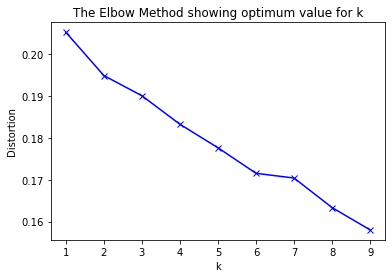

In [56]:
## Find best value of k for clustering, using elbow method
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# determine best k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(London_grouped_clustering)
    kmeanModel.fit(London_grouped_clustering)
    distortions.append(sum(np.min(cdist(London_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / London_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing optimum value for k')
plt.show()

## It is difficult to decipher a clear elbow from the above plot but there are gradient changes at k=3 and k=5, so I will use 4 as the optimal value

## create a new dataframe that includes the cluster label as well as the top 10 venues for each suburb

In [57]:
## add cluster labels
suburbs_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

London_merged = ELondon_df2

# merge London_grouped with London_data to add latitude/longitude for each suburb
London_merged2 = London_merged.join(suburbs_venues_sorted.set_index('Suburb'), on='Location')

In [58]:
London_merged2.describe

<bound method NDFrame.describe of                Location                          borough   latitude  \
0               Aldgate                         City[10]  51.514248   
1        Ardleigh Green                     Havering[12]  51.571247   
2              Barbican                         City[14]  51.520150   
3               Barking         Barking and Dagenham[14]  51.540268   
4           Barkingside                    Redbridge[15]  51.581935   
5             Becontree         Barking and Dagenham[20]  51.540311   
6       Becontree Heath         Barking and Dagenham[21]  51.561030   
7         Bethnal Green                Tower Hamlets[25]  51.530346   
8           Blackfriars                         City[27]  51.511585   
9             Blackwall                Tower Hamlets[28]  51.507938   
10                  Bow                Tower Hamlets[31]  51.530938   
11      Cambridge Heath                Tower Hamlets[40]  51.531954   
12         Canary Wharf                Towe

In [63]:
London_merged3 = London_merged2.dropna()
London_merged3.head()

,Location,borough,latitude,longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aldgate,City[10],51.514248,-0.075719,1.0,Hotel,Coffee Shop,Gym / Fitness Center,Restaurant,French Restaurant,Food Truck,Garden,South American Restaurant,Turkish Restaurant,Scenic Lookout
1,Ardleigh Green,Havering[12],51.571247,0.219080,1.0,Supermarket,Pub,Café,Fast Food Restaurant,Coffee Shop,Train Station,Grocery Store,Turkish Restaurant,Garden,Pharmacy
2,Barbican,City[14],51.520150,-0.098683,1.0,Coffee Shop,Gym / Fitness Center,Vietnamese Restaurant,Pub,Wine Bar,Plaza,Food Truck,Hotel,Beer Bar,French Restaurant
3,Barking,Barking and Dagenham[14],51.540268,0.079324,0.0,Hotel,Supermarket,Park,Grocery Store,Fast Food Restaurant,Coffee Shop,Pub,Pizza Place,Spa,Breakfast Spot
4,Barkingside,Redbridge[15],51.581935,0.070057,0.0,Grocery Store,Pizza Place,Park,Thai Restaurant,Hotel,English Restaurant,Steakhouse,Supermarket,Bakery,Pub


In [65]:
London_merged3['Cluster_Labels']= London_merged3['Cluster_Labels'].astype(int)
London_merged3.head()

<ipython-input-65-973e03a45a4e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  London_merged3['Cluster_Labels']= London_merged3['Cluster_Labels'].astype(int)


,Location,borough,latitude,longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aldgate,City[10],51.514248,-0.075719,1,Hotel,Coffee Shop,Gym / Fitness Center,Restaurant,French Restaurant,Food Truck,Garden,South American Restaurant,Turkish Restaurant,Scenic Lookout
1,Ardleigh Green,Havering[12],51.571247,0.219080,1,Supermarket,Pub,Café,Fast Food Restaurant,Coffee Shop,Train Station,Grocery Store,Turkish Restaurant,Garden,Pharmacy
2,Barbican,City[14],51.520150,-0.098683,1,Coffee Shop,Gym / Fitness Center,Vietnamese Restaurant,Pub,Wine Bar,Plaza,Food Truck,Hotel,Beer Bar,French Restaurant
3,Barking,Barking and Dagenham[14],51.540268,0.079324,0,Hotel,Supermarket,Park,Grocery Store,Fast Food Restaurant,Coffee Shop,Pub,Pizza Place,Spa,Breakfast Spot
4,Barkingside,Redbridge[15],51.581935,0.070057,0,Grocery Store,Pizza Place,Park,Thai Restaurant,Hotel,English Restaurant,Steakhouse,Supermarket,Bakery,Pub


## 9. Visualise resulting clusters

In [67]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(London_merged3['latitude'], London_merged3['longitude'], London_merged3['Location'], London_merged3['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters
### Now I examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, I assign a name to each cluster

## Cluster 0: Grocery stores, restaurants, pubs

In [68]:
London_merged3.loc[London_merged3['Cluster_Labels'] == 0, London_merged3.columns[[0, 1] + list(range(5, London_merged3.shape[1]))]]

,Location,borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Barking,Barking and Dagenham[14],Hotel,Supermarket,Park,Grocery Store,Fast Food Restaurant,Coffee Shop,Pub,Pizza Place,Spa,Breakfast Spot
4,Barkingside,Redbridge[15],Grocery Store,Pizza Place,Park,Thai Restaurant,Hotel,English Restaurant,Steakhouse,Supermarket,Bakery,Pub
6,Becontree Heath,Barking and Dagenham[21],Bus Stop,Supermarket,Liquor Store,Chinese Restaurant,Park,Grocery Store,Gym / Fitness Center,Electronics Store,Turkish Restaurant,Clothing Store
14,Castle Green,Barking and Dagenham,Pub,Grocery Store,Soccer Field,Bus Stop,Go Kart Track,Liquor Store,Convenience Store,Metro Station,Rugby Pitch,Pizza Place
15,Chadwell Heath,"Redbridge, Barking and Dagenham",Supermarket,Grocery Store,Pub,Indian Restaurant,Train Station,Gym,Gym / Fitness Center,Shopping Plaza,Pizza Place,Hardware Store
18,Collier Row,Havering,Coffee Shop,Pizza Place,Pub,Park,Grocery Store,Gym,Convenience Store,Construction & Landscaping,Gym / Fitness Center,Bakery
22,Dagenham,Barking and Dagenham,Grocery Store,Pub,Park,Bus Stop,Convenience Store,Furniture / Home Store,Shopping Mall,Coffee Shop,Supermarket,Bank
24,Elm Park,Havering,Grocery Store,Pizza Place,Skate Park,Park,Gym / Fitness Center,Cosmetics Shop,Café,Bakery,Coffee Shop,Yoga Studio
27,Gallows Corner,Havering,Fast Food Restaurant,Supermarket,Coffee Shop,Department Store,Bus Stop,Warehouse Store,Business Service,Gym / Fitness Center,Hardware Store,Pizza Place
28,Gants Hill,Redbridge,Pizza Place,Grocery Store,Thai Restaurant,Park,Bakery,Soccer Field,Chinese Restaurant,Pub,American Restaurant,Nightclub


## Cluster 1: Pubs, cafes, coffee shops, restaurants

In [70]:
London_merged3.loc[London_merged3['Cluster_Labels'] == 1, London_merged3.columns[[0, 1] + list(range(5, London_merged3.shape[1]))]]

,Location,borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aldgate,City[10],Hotel,Coffee Shop,Gym / Fitness Center,Restaurant,French Restaurant,Food Truck,Garden,South American Restaurant,Turkish Restaurant,Scenic Lookout
1,Ardleigh Green,Havering[12],Supermarket,Pub,Café,Fast Food Restaurant,Coffee Shop,Train Station,Grocery Store,Turkish Restaurant,Garden,Pharmacy
2,Barbican,City[14],Coffee Shop,Gym / Fitness Center,Vietnamese Restaurant,Pub,Wine Bar,Plaza,Food Truck,Hotel,Beer Bar,French Restaurant
5,Becontree,Barking and Dagenham[20],Soccer Field,Pub,Rugby Pitch,Skate Park,Park,Metro Station,Grocery Store,Chinese Restaurant,River,Convenience Store
7,Bethnal Green,Tower Hamlets[25],Coffee Shop,Pub,Café,Cocktail Bar,Hotel,Flower Shop,Restaurant,Yoga Studio,Bakery,Italian Restaurant
8,Blackfriars,City[27],Hotel,Coffee Shop,Pub,Theater,Park,Cocktail Bar,Gym / Fitness Center,Grocery Store,Scenic Lookout,Italian Restaurant
9,Blackwall,Tower Hamlets[28],Coffee Shop,Hotel,Italian Restaurant,Sandwich Place,Sushi Restaurant,Burger Joint,Café,Hotel Bar,Park,Plaza
10,Bow,Tower Hamlets[31],Pub,Café,Bus Stop,Coffee Shop,Pizza Place,Grocery Store,Art Gallery,Burger Joint,Park,Canal Lock
11,Cambridge Heath,Tower Hamlets[40],Coffee Shop,Café,Pub,Cocktail Bar,Bakery,Hotel,Flower Shop,Bookstore,Yoga Studio,Italian Restaurant
12,Canary Wharf,Tower Hamlets[40],Coffee Shop,Hotel,Italian Restaurant,Gym / Fitness Center,Plaza,Burger Joint,Sandwich Place,Park,Street Food Gathering,Steakhouse


## Cluster 2: Park, forest, pub, Chinese restaurant

In [71]:
London_merged3.loc[London_merged3['Cluster_Labels'] == 2, London_merged3.columns[[0, 1] + list(range(5, London_merged3.shape[1]))]]

,Location,borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Chase Cross,Havering,Coffee Shop,Pizza Place,Park,Department Store,English Restaurant,Warehouse Store,Furniture / Home Store,Bus Stop,Fast Food Restaurant,Yoga Studio
17,Chingford,Waltham Forest,Pub,Italian Restaurant,Coffee Shop,Grocery Store,History Museum,Café,Park,Golf Course,Athletics & Sports,Nature Preserve
19,Cranham,Havering,Coffee Shop,Park,Pub,Platform,Grocery Store,Soccer Stadium,Stationery Store,Metro Station,Supermarket,Sandwich Place
29,Gidea Park,Havering,Park,Grocery Store,Bus Stop,English Restaurant,Gym / Fitness Center,Electronics Store,Coffee Shop,Wine Shop,Shoe Store,Fish Market
33,Hackney Marshes,Hackney,Park,Nature Preserve,Market,Bus Stop,Café,Hockey Field,Plaza,Bistro,Filipino Restaurant,Farmers Market
36,Hainault,Redbridge,Park,Pub,Steakhouse,Bakery,Coffee Shop,Yoga Studio,Filipino Restaurant,Falafel Restaurant,Farm,Farmers Market
41,Highams Park,Waltham Forest,Pub,Hotel,Park,Coffee Shop,Gym,Clothing Store,Yoga Studio,Falafel Restaurant,Farm,Farmers Market
53,Loxford,Redbridge,Ice Cream Shop,Pub,Park,Portuguese Restaurant,Grocery Store,Convenience Store,Betting Shop,Coffee Shop,Pizza Place,Yoga Studio
59,North Ockendon,Havering,Coffee Shop,Pub,Campground,Motorcycle Shop,Yoga Studio,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
62,Rainham,Havering,Bus Stop,Park,Pizza Place,Gas Station,Pub,Chinese Restaurant,Museum,Fish & Chips Shop,Historic Site,Pet Store


## Cluster 3: Coffee shops, pubs and cafes

In [72]:
London_merged3.loc[London_merged3['Cluster_Labels'] == 3, London_merged3.columns[[0, 1] + list(range(5, London_merged3.shape[1]))]]

,Location,borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Creekmouth,Barking and Dagenham,Chinese Restaurant,Convenience Store,Warehouse Store,Flea Market,Filipino Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


## End of Analysis